In [3]:
import pandas as pd
import math
import time
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [4]:
def pprint(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

In [5]:
#GETS INSIDER ADJUSTED HOLDINGS FOR A GIVEN COMPANY
def get_insider_adj_holdings(sedol_df):
    sedol_df_list = []
    for date, year_sedol_df in sedol_df.groupby(['asof_date']): 
        block_holder_types = ['Individuals/Insiders', 'Corporations (Public)', 'Corporations (Private)']
        block_own = year_sedol_df[year_sedol_df['holder_type'].isin(block_holder_types)]['pct'].sum()
        
        if block_own < 100: 
            year_sedol_df['pct_mod'] = year_sedol_df['pct']/(100 - block_own) * 100
            year_sedol_df = year_sedol_df[~year_sedol_df['holder_type'].isin(block_holder_types)]
        else: 
            year_sedol_df['pct_mod'] = [math.nan for i in range(len(year_sedol_df))]
        
        sedol_df_list.append(year_sedol_df)
    sedol_df = pd.concat(sedol_df_list)
    return sedol_df

In [6]:
# GET VALUES FOR EACH TYPE OF INVESTOR
def get_breakdown(sedol_df):
    breakdown_df = sedol_df.groupby(['mod_orientation', 'asof_date']).sum()[['pct_mod']].reset_index()
    uninf_df = (100 - breakdown_df.groupby(['asof_date']).sum()[['pct_mod']]).reset_index()
    inf_df = breakdown_df[breakdown_df['mod_orientation']=='Active Informed']
    pass_df = breakdown_df[breakdown_df['mod_orientation']=='Passive']
    return uninf_df, inf_df, pass_df

def get_aggregate_breakdown(top_df):
    uninf_df_list, inf_df_list, pass_df_list = [], [], []
    for sedol, sedol_df in tqdm(top_df.groupby(['sedol'])): 
        uninf_df, inf_df, pass_df = get_breakdown(sedol_df)
        uninf_df_list.append(uninf_df)
        inf_df_list.append(inf_df)
        pass_df_list.append(pass_df)

    uninf_df_list_full, inf_df_list_full, pass_df_list_full = pd.concat(uninf_df_list), pd.concat(inf_df_list), pd.concat(pass_df_list)
    
    unif_agg_df = uninf_df_list_full.groupby('asof_date').mean().reset_index()
    inf_agg_df = inf_df_list_full.groupby('asof_date').mean().reset_index()
    pass_agg_df = pass_df_list_full.groupby('asof_date').mean().reset_index()
    
    return unif_agg_df, inf_agg_df, pass_agg_df

In [7]:
def plot_breakdown_3(uninf_df, inf_df, pass_df, title='Title', save_name='random'):
    x = list(pass_df['asof_date'] - pd.Timedelta(weeks=52))  
    x = date2num(x)
    ax = plt.subplot(111)
    ax.bar(x-100, pass_df['pct_mod'], width=100, color='b', align='center', label='Passive')
    ax.bar(x, inf_df['pct_mod'], width=100, color='g', align='center', label='Active Informed')
    ax.bar(x+100, uninf_df['pct_mod'], width=100, color='r', align='center', label='Active Uninformed')
    ax.legend(prop={'size':8})
    ax.xaxis_date()
    box = ax.get_position()
    
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 1])
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage of Free-Float")
    plt.tight_layout()
    plt.plot()
    plt.savefig(PATH+'images/' + save_name)

In [22]:
df = pd.read_csv(PATH+'raw_data/capital_iq/ownership_cleaned_r1.csv')
df = df[df.columns[1:]]
df = df[['ticker', 'sedol', 'comn', 'asof_date', 'name', 'holdings', 'pct', 'ciq', 'holder_type','date', 'orientation']]

c:\users\jackl\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
df['asof_date'] = pd.to_datetime(df['asof_date'])
df['date'] = pd.to_datetime(df['date'])
df['sedol'] = df['sedol'].astype(str)
df['comn'] = df['comn'].astype(str)
df['name'] = df['name'].astype(str)
df['holdings'] = df['holdings'].astype(float)
df['pct'] = df['pct'].astype(float)
df['ciq'] = df['ciq'].astype(str)
df['holder_type'] = df['holder_type'].astype(str)
df['orientation'] = df['orientation'].astype(str)
df['ticker'] = df['ticker'].astype(str)

In [24]:
# modifies orientation list
# makes individual owners marked as passive
o_list, h_list = list(df['orientation']), list(df['holder_type'])
mod_o_list = []
for i in range(len(o_list)):
    o, h = o_list[i], h_list[i]
    
    if o == 'Active':
        o = 'Active Informed'

    if h == 'VC/PE Firm': 
        mod_o_list.append('Active Informed')
    else: 
        mod_o_list.append(o)
        
df['mod_orientation'] = mod_o_list

In [25]:
#GET RID OF ERRONEOUS PCTS
df = df[~((df['holdings'] != 0) & (df['pct'] == 0))]

In [26]:
df['date_diff'] = abs(df['date'] - df['asof_date'])

In [27]:
df = df[df['date_diff'] < pd.Timedelta(days=365)]

In [28]:
# #GET COMPANY VARIABLES
# ret_df = pd.read_pickle(PATH+'checkpoint_data/returns_all_stocks.pkl')
# ret_df = ret_df[['datadate', 'cshoc', 'sedol']]

In [29]:
# df = pd.merge_asof(df.sort_values('date'), 
#                    ret_df.sort_values('datadate'), 
#                    by='sedol', 
#                    left_on=['date'], 
#                    right_on=['datadate'], 
#                    direction='backward')
# df['pct_manual'] = df['holdings']/df['cshoc'] * 100

In [30]:
#GET NIKKEI WEIGHTS
weight_df = pd.read_pickle(PATH+'checkpoint_data/index_weights.pkl')
nk_weights_df = weight_df[weight_df['indexlistmnem']=='LJAPDOWA'].groupby(['sedol']).mean()[['weight']].reset_index()
nk_weights_df.columns = ['sedol', 'nk_weight']
nk_weights_df['nk_weight_decile'] = pd.qcut(nk_weights_df['nk_weight'], 10, labels=False)

In [31]:
#MERGE WITH OWNERSHIP DF
df = pd.merge(df, nk_weights_df, on=['sedol'], how='left')

In [33]:
#ADJUST FOR INSIDER OWNERSHIP
df_list = []
for sedol, sedol_df in tqdm(df.groupby(['sedol'])): 
    df_list.append(get_insider_adj_holdings(sedol_df))
df_adj = pd.concat(df_list)

100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [00:35<00:00,  6.58it/s]


In [34]:
df_adj.to_pickle(PATH + 'checkpoint_data/ownership_data_cleaned.pkl')

In [40]:
df_non_adj = df

In [41]:
df_non_adj.to_pickle(PATH + 'checkpoint_data/ownership_data_cleaned_non_adj.pkl')

### Ownership Types Statistics

In [114]:
df.groupby(['holder_type', 'mod_orientation']).count()[['holdings']]

holdings
holder_type                    mod_orientation          
Bank/Investment Bank           0                     539
                               Active Informed      6819
Charitable Foundations         0                     204
                               Active Informed         2
Company-Controlled Foundations 0                      59
Corporate Pension Sponsors     0                    1092
                               Active Informed       325
Corporations (Private)         0                       2
Corporations (Public)          0                       1
ESOP                           0                    1071
Educational/Cultural Endowment 0                      79
                               Active Informed        18
Family Offices/Trust           0                      50
                               Active Informed      5188
                               Passive                43
Government Pension Sponsor     0                      82
                               Active Informed     13173
                               Passive              2046
Hedge Fund Manager             0                     229
                               Active Informed      8211
                               Passive               296
Insurance Company              0                     815
                               Active Informed       748
REITs                          0                     187
                               Active Informed        24
Sovereign Wealth Fund          0                     115
                               Active Informed         1
State Owned Shares             0                     216
Traditional Investment Manager 0                    4555
                               Active Informed    384514
                               Passive             74624
Unclassified                   0                     211
                               Active Informed        27
Union Pension Sponsor          0                      54
VC/PE Firm                     Active Informed      4054

In [19]:
q = df[df['mod_orientation']=='Active Informed']

In [20]:
a = q.groupby(['sedol', 'asof_date'])[['pct', 'sedol', 'asof_date']].sum().reset_index()

In [21]:
a.groupby(['asof_date']).mean()

,pct
asof_date,
2010-12-31,19.522400
2011-12-31,19.974397
2012-12-31,22.373464
2013-12-31,22.635923
2014-12-31,23.086718
2015-12-31,22.454306
2016-12-31,24.999606
2017-12-31,24.447222
2018-12-31,26.367767


### Fast Retail Case Study

In [13]:
# df[df['comn'].str.contains('FAST')]

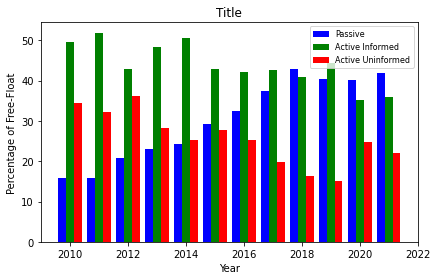

In [68]:
sedol = '6332439'
fast_df = df[df['sedol']==sedol]

uninf_df, inf_df, pass_df = get_breakdown(fast_df)
plot_breakdown_3(uninf_df, inf_df, pass_df)

### Onwership Split By Decile

In [115]:
top_df = df[df['nk_weight_decile'].isin([9])]
bot_df = df[df['nk_weight_decile'].isin([0])]

In [116]:
def get_aggregate_breakdown(top_df):
    uninf_df_list, inf_df_list, pass_df_list = [], [], []
    for sedol, sedol_df in tqdm(top_df.groupby(['sedol'])): 
        uninf_df, inf_df, pass_df = get_breakdown(sedol_df)
        uninf_df_list.append(uninf_df)
        inf_df_list.append(inf_df)
        pass_df_list.append(pass_df)

    uninf_df_list_full, inf_df_list_full, pass_df_list_full = pd.concat(uninf_df_list), pd.concat(inf_df_list), pd.concat(pass_df_list)
    
    unif_agg_df = uninf_df_list_full.groupby('asof_date').mean().reset_index()
    inf_agg_df = inf_df_list_full.groupby('asof_date').mean().reset_index()
    pass_agg_df = pass_df_list_full.groupby('asof_date').mean().reset_index()
    
    return unif_agg_df, inf_agg_df, pass_agg_df

In [117]:
top_uninf_agg_df, top_inf_agg_df, top_pass_agg_df = get_aggregate_breakdown(top_df)
bot_uninf_agg_df, bot_inf_agg_df, bot_pass_agg_df = get_aggregate_breakdown(bot_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.99it/s]


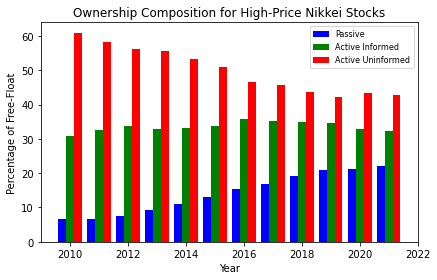

In [118]:
plot_breakdown_3(top_uninf_agg_df, 
                 top_inf_agg_df, 
                 top_pass_agg_df, 
                 title='Ownership Composition for High-Price Nikkei Stocks', 
                 save_name='ownership_high_priced_3')

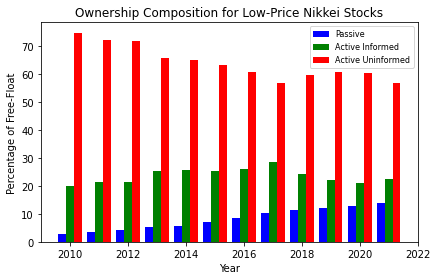

In [119]:
plot_breakdown_3(bot_uninf_agg_df, 
                 bot_inf_agg_df,
                 bot_pass_agg_df, 
                 title='Ownership Composition for Low-Price Nikkei Stocks', 
                 save_name='ownership_low_priced_3')